<a href="https://colab.research.google.com/github/kibbm/ML-Tensorflow/blob/master/Kmean%2C_Kmedois%2Chierachical_1102(%EC%98%A4%ED%9B%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

iris와 달팽이 모양의 
- K-means
- Hireacical Clustering
- DBSCAN
각각의 결과비교 및 각 data의 적정한 모형 찾기.

<실습>
- https://m.blog.naver.com/wideeyed/221534602937

<이론>
- https://ellun.tistory.com/105
- http://databaser.net/moniwiki/wiki.php/DBSCAN


 IRIS 입력 4개 필드를 2차원(X축, Y축)에 출력하며 확인하기위해 interact()를 사용합니다.

## **첫번째 K-mean(https://m.blog.naver.com/wideeyed/221534602937)**

1) 필요한 모듈을 읽습니다.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

2) IRIS 꽃 데이터를 읽습니다.



In [3]:
#IRIS 꽃 데이터를 읽고 순서를 섞는다.
iris_df = sns.load_dataset('iris').sample(frac=1).reset_index(drop=True)
iris_df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,6.3,2.8,5.1,1.5,virginica
1,5.4,3.7,1.5,0.2,setosa
2,5.0,3.6,1.4,0.2,setosa


3) x컬럼과 Y컬럼을 지정하고 Y컬럼은 문자열로 되어 있어 숫자로 인코딩합니다.

In [4]:
#사용할 X컬럼들과 Y컬럼을 지정한다.
x_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
y_column = 'species'

# Y컬럼의 문자열 값을 LabelEncoder를 통해 숫자로 바꾼다.
y_true_label_encoder = preprocessing.LabelEncoder()
y_true_encoded       = y_true_label_encoder.fit_transform(iris_df[y_column])
print(list(iris_df[y_column][:3]), '->', list(y_true_encoded[:3]))


['virginica', 'setosa', 'setosa'] -> [2, 0, 0]


4) k(=클러스터 개수)값을 2~9까지 조정하면서 KMeans 모델 생성 및 학습합니다.

In [5]:
kMeansModels              = dict() # k값별 모델 저장할 딕셔너리
kMeansModelPreds          = dict() # k값별 모델 예측 결과 저장할 딕셔너리
kMeansModelLabelEncoder   = dict() # k값별 라벨인코더 저장할 딕셔너리
# kMeansCenter   = dict() # k값별 라벨인코더 저장할 딕셔너리

sumSquaredDistancesList   = list() # 샘플과 클러스터 센터간 거리 제곱의 합 리스트
silhouetteScoreList       = list() # Silhouette Coefficient 평균 리스트

ks = [2,3,4,5,6,7,8,9] # k값으로 2부터 9까지 테스트한다
for k in ks: # k값 순회
    model = KMeans(n_clusters=k, random_state=0, n_init=100)  # k개 클러스터로 모델 생성
    cluster_labels = model.fit_predict(iris_df[x_columns]) # X컬럼으로 지정된 필드값으로 피팅
    
    y_pred_label_encoder = preprocessing.LabelEncoder() # 예측한 클러스터에서 사용할 라벨인코더
    # 초기 임의 값 (unknown 1, unknown 2...) 으로 인코딩한다
    y_pred_label_encoder.fit(np.array(['unknown ' + str(i+1) for i in range(0, k, 1)], dtype=object))
    for pred_label_num in range(0,k,1): # 각 클러스터 순회        
        # 해당 클러스터에서 가장 많이 출력한 실제 값의 인덱스를 구한다
        most_frequent_index = np.argmax(np.bincount(y_true_encoded[cluster_labels==pred_label_num]))
        # 구한 인덱스의 라벨을 구해서 해당클러스터 라벨로 업데이트한다
        y_pred_label_encoder.classes_[pred_label_num] = y_true_label_encoder.classes_[most_frequent_index]
    
    kMeansModels[k]     = model                       # 모델 저장
    kMeansModelPreds[k] = cluster_labels              # 모델 예측결과 저장     
    kMeansModelLabelEncoder[k] = y_pred_label_encoder # 라벨인코더 저장
    # kMeansCenter[k] = model.cluster_centers_
    kMeansCenter = pd.DataFrame(model.cluster_centers_)
    sumSquaredDistancesList.append(model.inertia_)    # # 샘플과 클러스터 센터간 거리 제곱의 합 저장
    silhouetteScoreList.append(silhouette_score(iris_df[x_columns].values, cluster_labels)) # Silhouette Score저장

In [6]:
kMeansCenter.columns=x_columns
kMeansCenter

,sepal_length,sepal_width,petal_length,petal_width
0,5.628571,2.723810,4.133333,1.295238
1,5.071429,3.504762,1.538095,0.280952
2,6.568182,3.086364,5.536364,2.163636
3,7.475000,3.125000,6.300000,2.050000
4,6.036842,2.705263,5.000000,1.778947
5,5.242857,2.371429,3.442857,1.028571
6,4.678947,3.084211,1.378947,0.200000
7,5.490000,3.920000,1.460000,0.260000
8,6.442105,2.978947,4.594737,1.431579


클러스터 개수에 따라 "샘플과 클러스터 센터간 거리 제곱의 합"을 그래프로 그려봅니다.

(센터가 많아질수록 여러 센터가 존재하므로 거리는 줄어들게 됩니다)

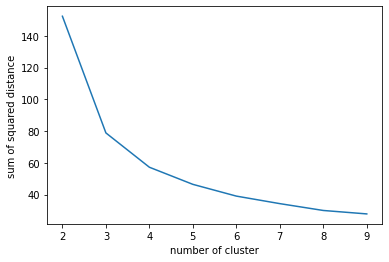

In [7]:
plt.plot(ks, sumSquaredDistancesList)
plt.xlabel("number of cluster")
plt.ylabel("sum of squared distance")
plt.show()

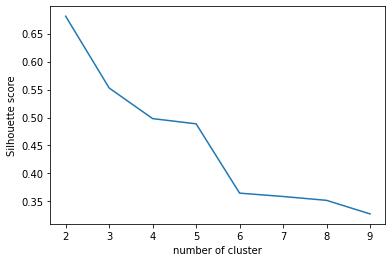

In [8]:
plt.plot(ks, silhouetteScoreList)
plt.xlabel("number of cluster")
plt.ylabel("Silhouette score")
plt.show()

드롭다운목록에서 선택하면서 사용자와 상호작용하면서 여러 그래프를 볼 수 있습니다.



In [9]:
def render_plot(x_col='petal_length', y_col='petal_width', k=3):
    y_pred        = kMeansModelPreds[k]        # 모델 예측값
    label_encoder = kMeansModelLabelEncoder[k] # 라벨인코더
    center = kMeansCenter
    # 원본과 예측값을 합쳐 데이터셋을 준비
    mdf = pd.concat([iris_df, pd.DataFrame(label_encoder.inverse_transform(y_pred), columns=[y_column+'_pred'])], axis=1)
    
    plt.figure(figsize=(15,8)) # 출력 크기를 지정
    
    ddf = mdf[mdf[y_column] != mdf[y_column+'_pred']] # 실제라벨과 예측라벨이 틀린 경우 추출
    # X기호로 error임을 표시한다
    plt.scatter(x=ddf[x_col], y=ddf[y_col], c='black', marker='x', s=300, label='error') 
    
    colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black'] # 컬러값 리스트
    for (idx,cls) in enumerate(list(y_true_label_encoder.classes_)):
        ddf = mdf[mdf[y_column] == cls] # 실제라벨 데이터는 작은 점으로 출력
        plt.scatter(x=ddf[x_col], y=ddf[y_col], c=colors[idx], marker='.', linewidths=3, s=50, label=cls)
        ddf = mdf[mdf[y_column+'_pred'] == cls] # 예측라벨 데이터는 큰 원으로 출력
        plt.scatter(x=ddf[x_col], y=ddf[y_col], c=colors[idx], marker='o', linewidths=13, s=2, label=cls+' pred')
    y_s=['setosa','versicolor', 'virginica']
    for i in range(k):
      plt.scatter(center[x_col][i],center[y_col][i], s=60,marker='D',c='black', label=' center')    
    
    plt.legend();plt.xlabel(x_col);plt.ylabel(y_col)
    print('accuracy {:.2f}'.format(np.mean(mdf[y_column] == mdf[y_column+'_pred']))) # 정확도 출력
    plt.show()

In [10]:
interact(render_plot, x_col=x_columns, y_col=x_columns, k=ks)

interactive(children=(Dropdown(description='x_col', index=2, options=('sepal_length', 'sepal_width', 'petal_le…

<function __main__.render_plot>

클러스터 3개인 경우를 볼까요?

정확도가 0.89입니다. 89%는 맞고 11%정도가 틀렸습니다.


## **두번째 K-mean, K-medois(https://eunsukimme.github.io/ml/2019/12/16/K-Means/)**

## **세 번째 hierachical (hierarchy) https://bcho.tistory.com/1204| https://joyfuls.tistory.com/64**

1. datasetload

In [25]:
from sklearn import datasets
import pandas as pd
iris = datasets.load_iris()

labels = pd.DataFrame(iris.target)
labels.columns=['labels']
data = pd.DataFrame(iris.data)
data.columns=['Sepal length','Sepal width','Petal length','Petal width']
data = pd.concat([data,labels],axis=1)

data.head()

,Sepal length,Sepal width,Petal length,Petal width,labels
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [26]:
labels

,labels
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


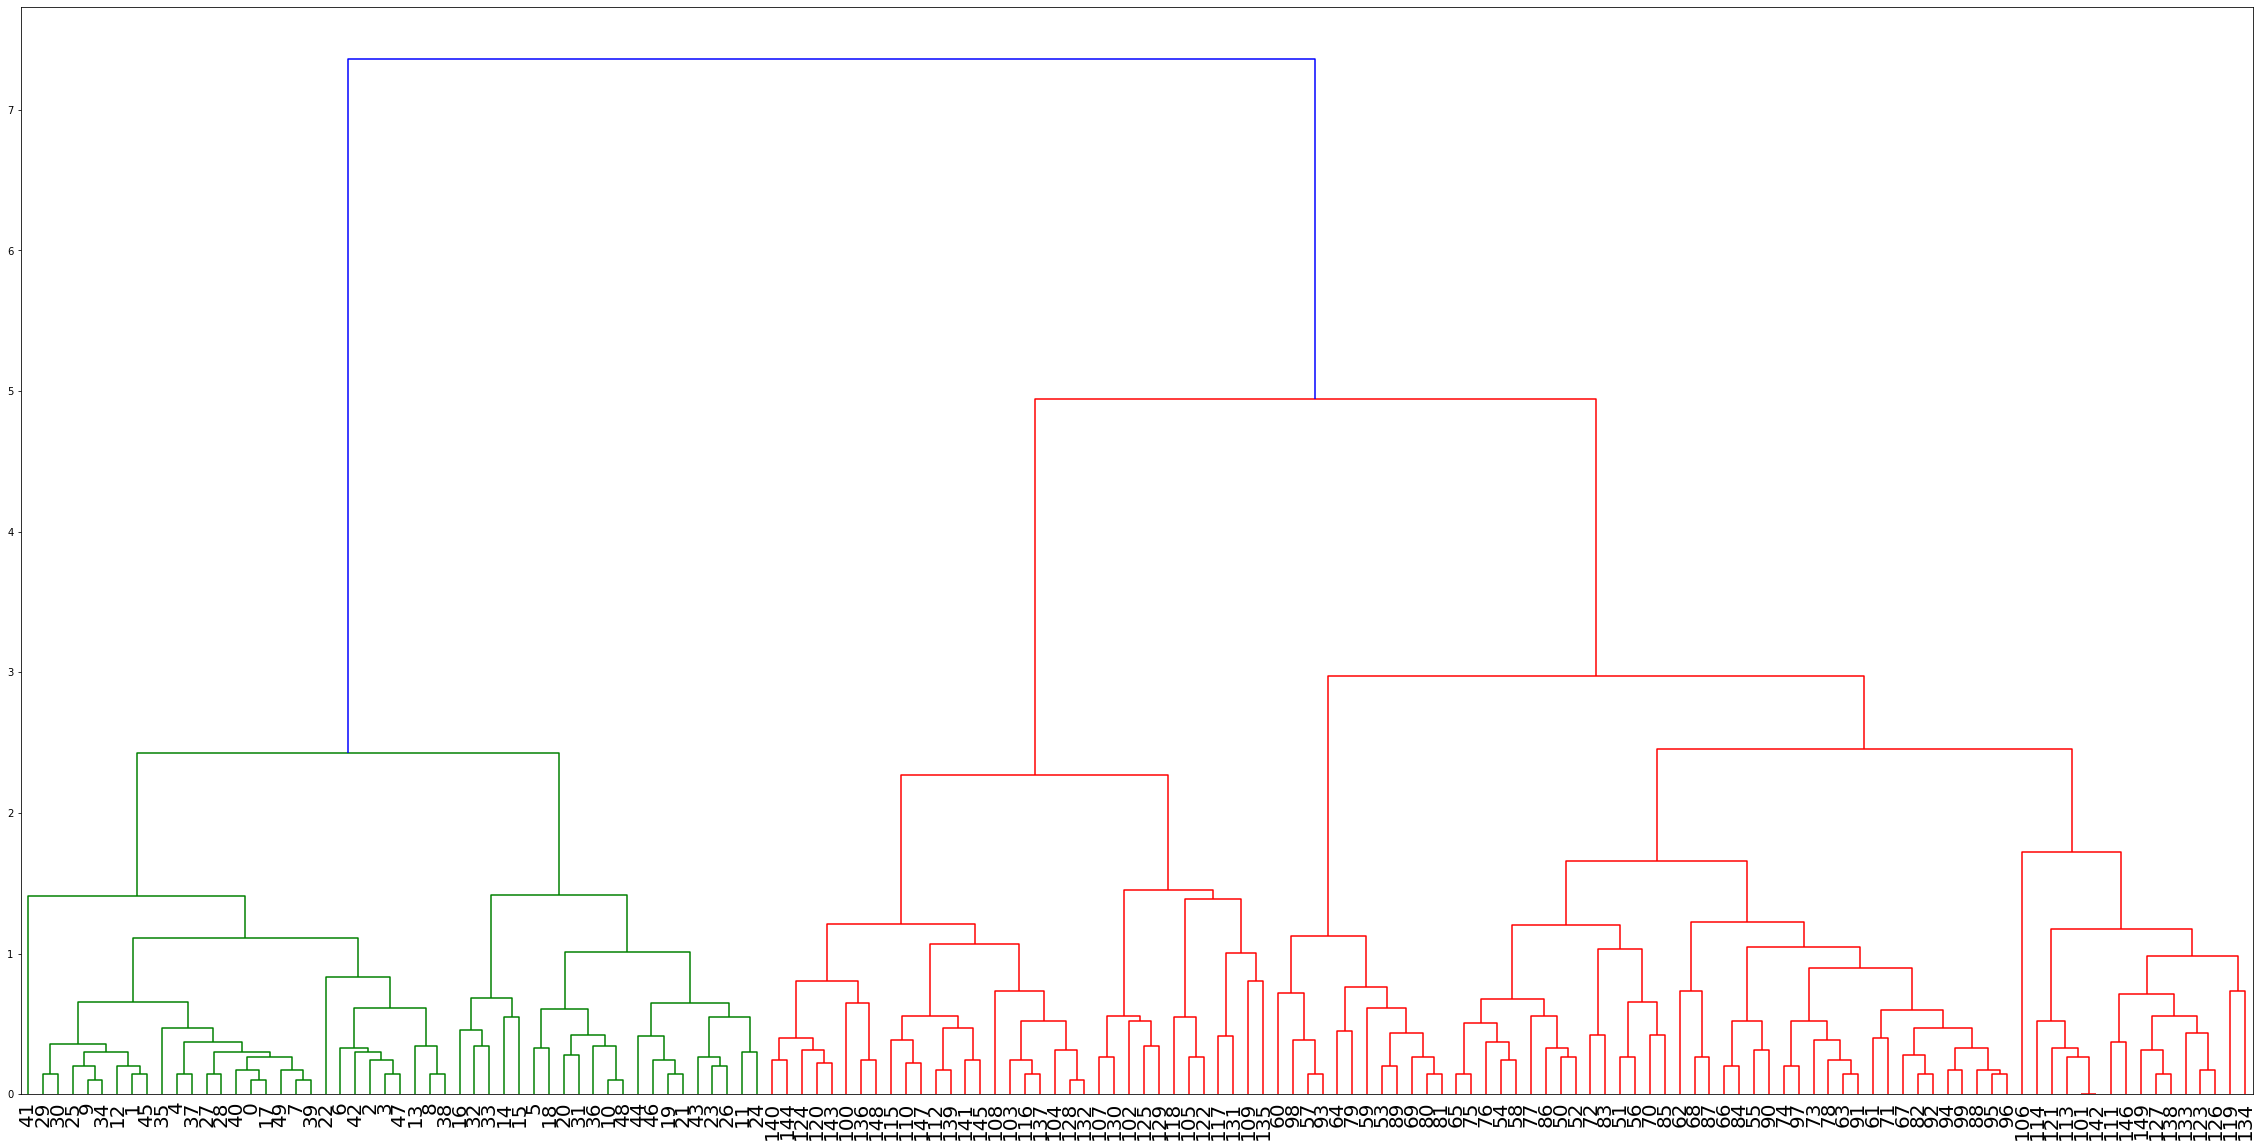

In [36]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# linkage계산하기
#mergings = linkage(data, method='complete')
mergings = linkage(data, method='complete', metric='euclidean')
#mergings
#mergings.shape

# 덴드로그램 그리기
plt.figure(figsize=(40, 20))
dendrogram(mergings, leaf_rotation=90, leaf_font_size=20)
plt.show()


In [42]:
from scipy.cluster.hierarchy import fcluster

prediction = pd.DataFrame(fcluster(mergings, 3, criterion='distance'))
prediction
#cut_tree = fcluster(mergings, 3, criterion='distance')
#cut_tree  


predict.columns = ['predict']
ct = pd.crosstab(predict['predict'], labels['labels'])
print(ct)

labels    0   1   2
predict            
1        50   0   0
2         0   0  34
3         0  50  16


In [43]:
# test용 추가

from sklearn.datasets import load_iris
import seaborn as sns

X, y = load_iris(return_X_y=True)
#====
samples = iris.data

target = iris.target
target

species = np.chararray(target.shape, itemsize=150)
for i in range(len(samples)):
  if target[i] == 0:
    species[i] = 'setosa'
  elif target[i] == 1:
    species[i] = 'versicolor'
  elif target[i] == 2:
    species[i] = 'virginica'

iris['Species'].value_counts() #Species: y변수

KeyError: ignored

## **비정형 데이터 http://databaser.net/moniwiki/wiki.php/DBSCAN**
https://m.blog.naver.com/ssdyka/221273386455
https://wikidocs.net/84774
https://bcho.tistory.com/1205



DBSCAN은 데이터의 밀집 지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분된다는 것이다. 밀집 지역에 있는 포인트를 핵심 심플(핵심 포인트)라고 한다.  
- 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾는다. 이런 지역을 특성공간의 밀집지역(dense region)이라고 한다.  
- 군집 알고리즘이고, 매개변수가 min_sample, eps 2개다. 한 데이터 포인트에서 eps거리 안에 데이터가 min_sample 개수만큼 들어있으면 이 데이터 포인트를 핵심 샘플로 분류한다. eps보다 가까운 핵심 샘플은 DBScan에 의해 동일한 클러스터로 합쳐진다. 



**DBSCAN(min_sample, eps)**은 군집 알고리즘이고, 매개변수가 2개다.

*   min_sample
*   eps



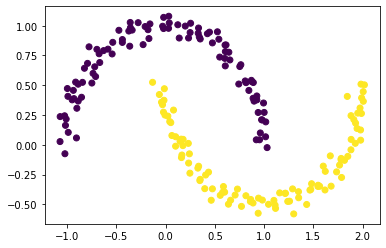

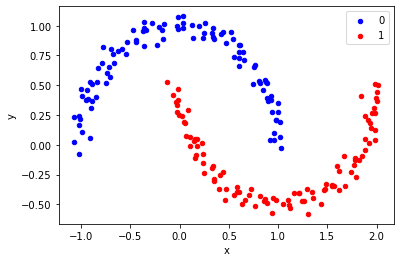

In [44]:
#two_moon 데이터 셋
from sklearn.datasets import make_moons
import pandas as pd
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

df = pd.DataFrame(X, columns=["x", "y"])
df["group"] = y
df[:5]

#import matplotlib.pyplot as plt
#plt.scatter(x=df.x, y=df.y, c=df.group)

#<scatter plot>: 여기부터
import matplotlib.pyplot as plt
plt.scatter(x=df.x, y=df.y, c=df.group)

fig, ax = plt.subplots()
colors = {1:'red', 0:'blue'}

grouped = df.groupby('group')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

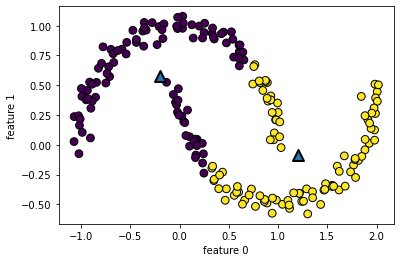

In [45]:
from sklearn.cluster import KMeans

x, y = make_moons(n_samples=200, noise=0.05, random_state=0) # 갯수, 퍼짐정도, 랜덤상태

kmeans = KMeans(n_clusters=2).fit(x) # 모델 객체 생성 및 학습

y_pred = kmeans.predict(x) # 모델 적용

plt.scatter(x[:, 0], x[:, 1], c=y_pred, s=60, edgecolors='black')# x, y, group, 점크기 60%, 테두리색 black, palette
#, cmap=mglearn.cm2) 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], # x, y
            marker='^', s=120, linewidth=2, edgecolors='k')# marker,  점크기 120%, 두께, 테두리색, 색상 
            # , c=[mglearn.cm2(0), mglearn.cm2(1)]) 
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()

Text(0, 0.5, 'y')

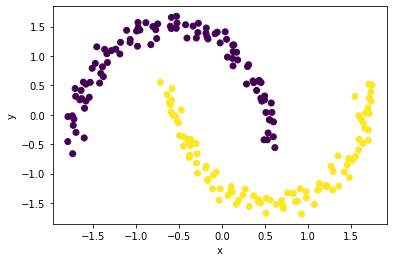

In [46]:
#표준화(평균=0, 분산=1)
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(df[["x", "y"]])
scaled_X = scale.transform(df[["x", "y"]])

df["scaled_x"] = scaled_X[:,0]
df["scaled_y"] = scaled_X[:,1]

#DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5) #기본값이다.
cluster = dbscan.fit_predict(scaled_X)
df["cluster"] = cluster

#clustering 결과 확인
plt.scatter(x=df.scaled_x, y=df.scaled_y, c=df.cluster)
plt.xlabel("x")
plt.ylabel("y")